### Import Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf

Using TensorFlow backend.


### Read Dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


### Classes

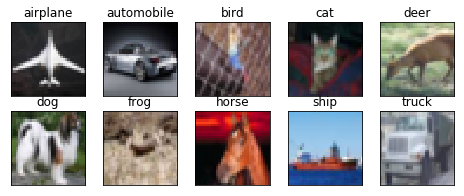

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Functions for Post Training Analysis

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Preparing Data

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Modified Code

#### Model Architecture

In [0]:
# Define the model
input = Input(shape=(32, 32, 3,))

L2 = SeparableConv2D(32, (5, 5), input_shape=(32, 32, 3), padding='same', name='L2')(input) # Dim 32
bn = BatchNormalization()(L2)
relu = Activation('relu')(bn)
L2 = Dropout(0.2)(relu)

L3 = Convolution2D(32, (5, 5), padding='same', name='L3')(L2) # Dim 32
bn = BatchNormalization()(L3)
relu = Activation('relu')(bn)
L3 = Dropout(0.2)(relu)

L4 = Convolution2D(64, (5, 5), padding='same', name='L4')(L3) # Dim 32
bn = BatchNormalization()(L4)
relu = Activation('relu')(bn)
L4 = Dropout(0.2)(relu)

L5_in = Concatenate(axis=-1)([L4,L2])
L5_in = Convolution2D(32, (1, 1), activation='relu', name='L5_1x1')(L5_in) # Dim 32
L5 = SeparableConv2D(64, (5, 5), padding='same', name='L5')(L5_in) # L2, 
bn = BatchNormalization()(L5)
relu = Activation('relu')(bn)
L5 = Dropout(0.2)(relu)

L6_in = Concatenate(axis=-1)([L5,L2])
L6_in = Convolution2D(32, (1, 1), activation='relu', name='L6_1x1')(L6_in) # Dim 32
L6 = MaxPooling2D(pool_size=(2, 2), name='L6')(L6_in) # L2, 


L2 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L2_lambda1')(L2)
L3 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L3_lambda1')(L3)
L4 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L4_lambda1')(L4)
L5 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L5_lambda1')(L5)

L7 = SeparableConv2D(64, (3, 3), padding='same', name='L7')(L6)  # Dim 16
bn = BatchNormalization()(L7)
relu = Activation('relu')(bn)
L7 = Dropout(0.2)(relu)

L8_in = Concatenate(axis=-1)([L7,L5,L2])
L8_in = Convolution2D(48, (1, 1), activation='relu', name='L8_1x1')(L8_in) # Dim 16
L8 = Convolution2D(64, (5, 5), padding='same', name='L8')(L8_in) # L2, L5
bn = BatchNormalization()(L8)
relu = Activation('relu')(bn)
L8 = Dropout(0.2)(relu)

L9_in = Concatenate(axis=-1)([L8,L7,L5,L4])
L9_in = Convolution2D(64, (1, 1), activation='relu', name='L9_1x1')(L9_in) # Dim 16
L9 = SeparableConv2D(80, (3, 3), padding='same', name='L9')(L9_in) # L4, L5, L7
bn = BatchNormalization()(L9)
relu = Activation('relu')(bn)
L9 = Dropout(0.2)(relu)

L10_in = Concatenate(axis=-1)([L9,L8,L7,L5,L4,L2])
L10_in = Convolution2D(96, (1, 1), activation='relu', name='L10_1x1')(L10_in) # Dim 16
L10 = SeparableConv2D(128, (5, 5), padding='same', name='L10')(L10_in) # L2, L4, L5, L7, L8
bn = BatchNormalization()(L10)
relu = Activation('relu')(bn)
L10 = Dropout(0.2)(relu)

L11_in = Concatenate(axis=-1)([L10,L9,L7,L5,L2])
L11_in = Convolution2D(64, (1, 1), activation='relu', name='L11_1x1')(L11_in) # Dim 16
L11 = MaxPooling2D(pool_size=(2, 2), name='L11')(L11_in) # L2, L5, L7, L9


L2 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L2_lambda2')(L2)
L3 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L3_lambda2')(L3)
L4 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L4_lambda2')(L4)
L5 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L5_lambda2')(L5)
L7 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L7_lambda2')(L7)
L8 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L8_lambda2')(L8)
L9 = Lambda(lambda x: tf.nn.space_to_depth(x,2), name='L9_lambda2')(L9)


L12_in = Concatenate(axis=-1)([L11,L8])
L12_in = Convolution2D(48, (1, 1), activation='relu', name='L12_1x1')(L12_in) # Dim 8
L12 = Convolution2D(64, (5, 5), padding='same', name='L12')(L12_in) # L8
bn = BatchNormalization()(L12)
relu = Activation('relu')(bn)
L12 = Dropout(0.2)(relu)

L13_in = Concatenate(axis=-1)([L12,L9,L3,L5])
L13_in = Convolution2D(64, (1, 1), activation='relu', name='L13_1x1')(L13_in) # Dim 8
L13 = SeparableConv2D(80, (5, 5), padding='same', name='L13')(L13_in) # L3, L5, L9
bn = BatchNormalization()(L13)
relu = Activation('relu')(bn)
L13 = Dropout(0.2)(relu)

L14_in = Concatenate(axis=-1)([L13,L12,L7,L4,L3])
L14_in = Convolution2D(80, (1, 1), activation='relu', name='L14_1x1')(L14_in) # Dim 8
L14 = Convolution2D(96, (3, 3), padding='same', name='L14')(L14_in) # L3, L4, L7, L12
bn = BatchNormalization()(L14)
relu = Activation('relu')(bn)
L14 = Dropout(0.2)(relu)

L15_in = Concatenate(axis=-1)([L14,L13,L9,L7,L5,L4,L2])
L15_in = Convolution2D(128, (1, 1), activation='relu', name='L15_1x1')(L15_in) # Dim 8
L15 = SeparableConv2D(144, (5, 5), padding='same', name='L15')(L15_in) # L2, L4, L5, L7, L9, L13
bn = BatchNormalization()(L15)
relu = Activation('relu')(bn)
L15 = Dropout(0.2)(relu)

L16_in = Concatenate(axis=-1)([L15,L13,L9,L5])
# L16_in = Convolution2D(32, (1, 1), padding='same')(L16_in)

output = Convolution2D(10, (1, 1), activation='relu')(L16_in) # Dim 8
outputConv = Convolution2D(10, 8)(output)
flatten = Flatten()(outputConv)
L16 = Activation('softmax')(flatten) # L5, L9, L13

W0618 10:26:04.011085 140637286004608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 10:26:04.051831 140637286004608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 10:26:04.061029 140637286004608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 10:26:04.115928 140637286004608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 10:26:04.117084 1406372860

#### Model Summary

In [0]:
model = Model(inputs=[input], outputs=[L16])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
L2 (SeparableConv2D)            (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         L2[0][0]                         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

#### Model Compile and Training

W0618 10:26:08.839784 140637286004608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`
W0618 10:26:12.501874 14063728600460

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.0020000001.
195/195 [==============================] - 63s 321ms/step - loss: 1.6003 - acc: 0.4098 - val_loss: 1.5926 - val_acc: 0.4606

Epoch 00001: val_acc improved from -inf to 0.46060, saving model to Assignment7//maxAccuracy.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0020000001.
195/195 [==============================] - 53s 272ms/step - loss: 1.2081 - acc: 0.5662 - val_loss: 1.3947 - val_acc: 0.5084

Epoch 00002: val_acc improved from 0.46060 to 0.50840, saving model to Assignment7//maxAccuracy.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0020000001.
195/195 [==============================] - 52s 268ms/step - loss: 1.0060 - acc: 0.6407 - val_loss: 1.2521 - val_acc: 0.5855

Epoch 00003: val_acc improved from 0.50840 to 0.58550, saving model to Assignment7//maxAccuracy.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0

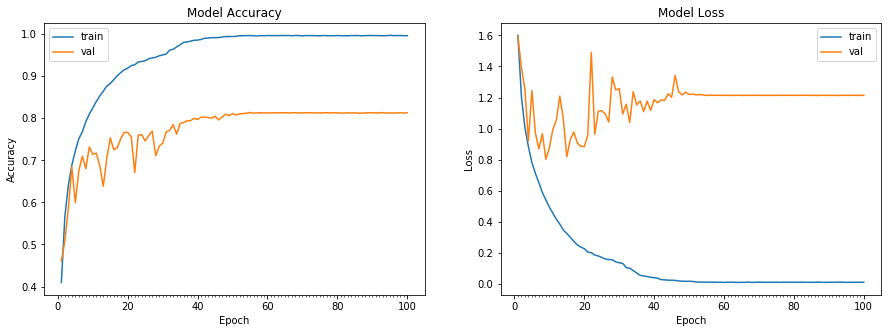

Accuracy on test data is: 81.30


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Image Normalization
datagen = ImageDataGenerator(zoom_range=0.0,featurewise_center=True, featurewise_std_normalization=True,
                             horizontal_flip=False)

# LR Scheduler
def scheduler(epoch, lr):
    if epoch > 80:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.5
    elif epoch >30:
      lr *= 0.9
    return round(lr, 10)

# Compile Model
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.002),
              metrics=['accuracy'])

# Checkpoint to save best model
!mkdir "Assignment7"
filepath="Assignment7//maxAccuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]


start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))